In [2]:
import numpy as np
from scipy.optimize import root_scalar, minimize, minimize_scalar
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import io
import tqdm

In [3]:
def calculate_L(radian, x1, y1, theta1, arc_length, l1, l2):
    # 计算theta的单位向量
    v = np.array([np.cos(theta1), np.sin(theta1)])
    if radian > -0.001 and radian < 0.001:
        # 按照直线计算
        # 计算arc_length的向量，arc_length的方向是theta的垂直方向
        v_arc = np.array([-np.sin(theta1), np.cos(theta1)])
        # 计算S1和S2的坐标
        S1_x = x1 + l1 * v[0]
        S1_y = y1 + l1 * v[1]
        S2_x = x1 + l2 * v[0] + arc_length * v_arc[0]
        S2_y = y1 + l2 * v[1] + arc_length * v_arc[1]
        return np.linalg.norm([S2_x - S1_x, S2_y - S1_y])
    
    # 计算半径
    radius = arc_length / radian
    
    # 计算圆心坐标，x1, y1为圆弧的起点，theta1为圆弧的起始角度，radian为圆弧的弧度，radius为圆弧的半径
    x0 = x1 - radius * np.cos(theta1)
    y0 = y1 - radius * np.sin(theta1)
    # print(f"x0: {x0}, y0: {y0}")

    # 计算圆弧两端点的坐标
    x2 = x1 + arc_length * np.cos(theta1 + radian + np.pi / 2)
    y2 = y1 + arc_length * np.sin(theta1 + radian + np.pi / 2)
    # print(f"x2: {x2}, y2: {y2}")
    
    # 计算圆心到圆弧两端点的单位向量
    v1 = np.array([x1 - x0, y1 - y0])
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.array([x2 - x0, y2 - y0])
    v2 = v2 / np.linalg.norm(v2)
    # print(f"v1: {v1}, v2: {v2}")
    
    # 计算穿线点S1和S2的坐标
    if radian <0:
        l1 = -l1
        l2 = -l2
    S1_x = x1 + l1 * v1[0]
    S1_y = y1 + l1 * v1[1]
    S2_x = x2 + l2 * v2[0]
    S2_y = y2 + l2 * v2[1]
    # print(f"S1_x: {S1_x}, S1_y: {S1_y}, S2_x: {S2_x}, S2_y: {S2_y}")
    
    # 计算实际L
    return np.linalg.norm([S2_x - S1_x, S2_y - S1_y])

def find_radian(x1, y1, theta1, arc_length, l1, l2, target_string_length):
    # print("x1: ", x1, "y1: ", y1, "theta1: ", theta1, "arc_length: ", arc_length, "l1: ", l1, "l2: ", l2, "target_string_length: ", target_string_length)
    def f(r):
        err = calculate_L(r, x1, y1, theta1, arc_length, l1, l2) - target_string_length
        # print(f"r: {r}, err: {err}")
        return err
    
    # 这里必须设置取值范围，否则可能会出现异常解。限定在+-1.8pi之间就能满足大部分需求了
    # result = minimize_scalar(f, bounds=(-np.pi*1.8, np.pi*1.8), method='bounded').x # 这两种都是有时好用有时不好用的
    result = root_scalar(f, bracket=(-np.pi*1.8, np.pi*1.8), method='newton', x0=0.001, x1=-0.001).root # 难顶
    return result

# 示例使用
x1 = 0
y1 = 0
theta1 = 0
arc_length = 1.5
l1 = 0
l2 = 0
L = 1.5

# radian = find_radian(x1, y1, theta1, arc_length, l1, l2, L)
# print(f"The calculated radian is: {radian}")
# radian = find_radian(x1, y1, theta1, arc_length, -l1, -l2, L)
# print(f"The calculated radian is: {radian}")
# test_L = calculate_L(0.1, x1, y1, theta1, arc_length, l1, -l2)
# print(f"The calculated L is: {test_L}")
# test_L = calculate_L(-0.1, x1, y1, theta1, arc_length, -l1, l2)
# print(f"The calculated L is: {test_L}")


In [4]:
def calculate_geometry(rod_length, x1, y1, theta1, arc_length, radians, l):
    result = {
        "rods": [],
        "arcs": [],
        "strings": []
    }
    
    x, y, theta = x1, y1, theta1
    
    # 计算第一根rod
    rod_start = (x - rod_length/2 * np.cos(theta), y - rod_length/2 * np.sin(theta))
    rod_end = (x + rod_length/2 * np.cos(theta), y + rod_length/2 * np.sin(theta))
    result["rods"].append([rod_start, rod_end])
    
    for i, radian in enumerate(radians):
        if radian > -0.001 and radian < 0.001:
            result["arcs"].append({
                "center": (np.inf, np.inf),
                "radius": float('inf'),
                "start_angle": theta,
                "end_angle": theta,
                "line": [(x, y), (x + arc_length * np.cos(theta+np.pi/2), y + arc_length * np.sin(theta+np.pi/2))]
            })
            x_next = x + arc_length * np.cos(theta + np.pi/2)
            y_next = y + arc_length * np.sin(theta + np.pi/2)
            rod_start = (x_next - rod_length/2 * np.cos(theta), 
                         y_next - rod_length/2 * np.sin(theta))
            rod_end = (x_next + rod_length/2 * np.cos(theta),
                          y_next + rod_length/2 * np.sin(theta))
            result["rods"].append([rod_start, rod_end])
            if i == 0:  # 第一个string
                string_start = (x + l[0] * np.cos(theta), y + l[0] * np.sin(theta))
            else:
                string_start = result["strings"][-1][1]  # 上一个string的终点
            string_end = (x_next + l[i+1] * np.cos(theta), y_next + l[i+1] * np.sin(theta))
            result["strings"].append([string_start, string_end])
            x, y = x_next, y_next
            continue
        # 计算半径
        radius = arc_length / radian
        
        # 计算圆弧
        circle_center_x = x - radius * np.sin(theta + np.pi/2)
        circle_center_y = y + radius * np.cos(theta + np.pi/2)
        arc_start_angle = theta
        arc_end_angle = arc_start_angle + radian
        
        result["arcs"].append({
            "center": (circle_center_x, circle_center_y),
            "radius": radius,
            "start_angle": arc_start_angle if radian >= 0 else arc_end_angle,
            "end_angle": arc_end_angle if radian >= 0 else arc_start_angle
        })
        
        # 计算圆弧终点
        x_next = circle_center_x + radius * np.cos(arc_end_angle)
        y_next = circle_center_y + radius * np.sin(arc_end_angle)
        
        # 计算R向量
        R_x = x_next - circle_center_x
        R_y = y_next - circle_center_y
        if radian < 0:
            R_x, R_y = -R_x, -R_y
        R_unit = np.array([R_x, R_y]) / np.linalg.norm([R_x, R_y])
        theta_next = np.arctan2(R_y, R_x)
        
        # 计算下一根rod
        rod_start = (x_next - rod_length/2 * np.cos(theta_next), 
                     y_next - rod_length/2 * np.sin(theta_next))
        rod_end = (x_next + rod_length/2 * np.cos(theta_next), 
                   y_next + rod_length/2 * np.sin(theta_next))
        result["rods"].append([rod_start, rod_end])
        
        # 计算string
        if i == 0:  # 第一个string
            string_start = (x + l[0] * np.cos(theta), y + l[0] * np.sin(theta))
        else:
            string_start = result["strings"][-1][1]  # 上一个string的终点
        
        string_end = (x_next + l[i+1] * R_unit[0], y_next + l[i+1] * R_unit[1])
        result["strings"].append([string_start, string_end])
        
        # 更新下一次迭代的起始点
        x, y, theta = x_next, y_next, theta_next
    
    return result

def calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, string_lengths, l):
    radians = []
    x, y, theta = x1, y1, theta1
    for i, L in enumerate(string_lengths):
        radian = find_radian(x, y, theta, arc_length, l[i], l[i+1], L)
        x, y, theta = calculate_next_point(x, y, theta, arc_length, radian)
        radians.append(radian)
    return radians

# 辅助函数：计算下一个点的位置和角度
def calculate_next_point(x, y, theta, arc_length, radian):
    if radian > -0.001 and radian < 0.001:
        x_next = x + arc_length * np.cos(theta + np.pi/2)
        y_next = y + arc_length * np.sin(theta + np.pi/2)
        return x_next, y_next, theta + radian
    # 计算半径
    radius = arc_length / radian
    
    # 计算圆弧
    circle_center_x = x - radius * np.sin(theta + np.pi/2)
    circle_center_y = y + radius * np.cos(theta + np.pi/2)
    arc_end_angle = theta + radian
    
    # 计算圆弧终点
    x_next = circle_center_x + radius * np.cos(arc_end_angle)
    y_next = circle_center_y + radius * np.sin(arc_end_angle)
    return x_next, y_next, arc_end_angle

# 示例使用
# rod_length = 2
# x1, y1 = 0, 0
# theta1 = 0
# arc_length = 1.5
# radians = [0.3, -0.25, -0.214]  # 三个级联的弧度
# l = [-0.5, -0.5, 0.5, 0.5]  # 四个l值，用于三个级联

# result = calculate_geometry(rod_length, x1, y1, theta1, arc_length, radians, l)

# print(f"Number of rods: {len(result['rods'])}")
# print(f"Number of arcs: {len(result['arcs'])}")
# print(f"Number of strings: {len(result['strings'])}")
# print(result)

In [5]:
def plot_geometry(geometry_result):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制rods（黑色，较粗）
    for rod in geometry_result['rods']:
        x_values = [rod[0][0], rod[1][0]]
        y_values = [rod[0][1], rod[1][1]]
        ax.plot(x_values, y_values, color='black', linewidth=2)
    
    # 绘制arcs（红色，较粗）
    for arc in geometry_result['arcs']:
        center = arc['center']
        radius = arc['radius']
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        if radius != float('inf'):
            arc_patch = Arc(center, 2*radius, 2*radius,
                            angle=0, theta1=np.degrees(start_angle),
                            theta2=np.degrees(end_angle),
                            color='red', linewidth=2)
            ax.add_patch(arc_patch)
        else: # 画直线，用line参数
            x_values = [arc['line'][0][0], arc['line'][1][0]]
            y_values = [arc['line'][0][1], arc['line'][1][1]]
            ax.plot(x_values, y_values, color='red', linewidth=2)
    
    # 绘制strings（蓝色，较细）
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        ax.plot(x_values, y_values, color='blue', linewidth=1)
    
    # 设置坐标轴等比例
    ax.set_aspect('equal', 'box')
    
    # 添加标题和标签
    plt.title('Geometry Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # 显示网格
    plt.grid(True)
    
    # 自动调整坐标轴范围
    ax.autoscale()
    
    # 显示图形
    plt.show()

# # 使用示例
# plot_geometry(result)

def create_geometry_gif(geometry_results, x_range, y_range, interval=200, filename='geometry_animation.gif'):
    if not geometry_results:
        print("Error: geometry_results is empty")
        return

    fig, ax = plt.subplots(figsize=(10, 10))

    def update(frame):
        ax.clear()
        if frame >= len(geometry_results):
            print(f"Error: frame {frame} is out of range. Total frames: {len(geometry_results)}")
            return
        
        geometry_result = geometry_results[frame]
        
        if not isinstance(geometry_result, dict):
            print(f"Error: Invalid geometry_result at frame {frame}. Expected dict, got {type(geometry_result)}")
            return

        # 绘制rods（黑色，较粗）
        if 'rods' in geometry_result:
            for rod in geometry_result['rods']:
                if len(rod) != 2 or not all(len(point) == 2 for point in rod):
                    print(f"Error: Invalid rod data at frame {frame}: {rod}")
                    continue
                x_values = [rod[0][0], rod[1][0]]
                y_values = [rod[0][1], rod[1][1]]
                ax.plot(x_values, y_values, color='black', linewidth=2)
        
        # 绘制arcs（红色，较粗）
        if 'arcs' in geometry_result:
            for arc in geometry_result['arcs']:
                if not all(key in arc for key in ['center', 'radius', 'start_angle', 'end_angle']):
                    print(f"Error: Invalid arc data at frame {frame}: {arc}")
                    continue
                center = arc['center']
                radius = arc['radius']
                start_angle = arc['start_angle']
                end_angle = arc['end_angle']
                if radius != float('inf'):
                    arc_patch = Arc(center, 2*radius, 2*radius,
                                    angle=0, theta1=np.degrees(start_angle),
                                    theta2=np.degrees(end_angle),
                                    color='red', linewidth=2)
                    ax.add_patch(arc_patch)
                else: # 画直线，用line参数
                    if 'line' not in arc or len(arc['line']) != 2:
                        print(f"Error: Invalid line data for infinite radius arc at frame {frame}: {arc}")
                        continue
                    x_values = [arc['line'][0][0], arc['line'][1][0]]
                    y_values = [arc['line'][0][1], arc['line'][1][1]]
                    ax.plot(x_values, y_values, color='red', linewidth=2)
        
        # 绘制strings（蓝色，较细）
        if 'strings' in geometry_result:
            for string in geometry_result['strings']:
                if len(string) != 2 or not all(len(point) == 2 for point in string):
                    print(f"Error: Invalid string data at frame {frame}: {string}")
                    continue
                x_values = [string[0][0], string[1][0]]
                y_values = [string[0][1], string[1][1]]
                ax.plot(x_values, y_values, color='blue', linewidth=1)
        
        # 设置坐标轴等比例
        ax.set_aspect('equal', 'box')
        
        # 添加标题和标签
        ax.set_title(f'Geometry Visualization (Frame {frame + 1}/{len(geometry_results)})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        # 显示网格
        ax.grid(True)
        
        # 设置坐标轴范围
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

    # 创建动画
    anim = FuncAnimation(fig, update, frames=len(geometry_results), interval=interval, blit=False)

    # 保存为GIF
    try:
        anim.save(filename, writer='pillow', fps=1000/interval)
    except Exception as e:
        print(f"Error saving GIF: {e}")
    
    plt.close(fig)

In [6]:
def get_original_string_length(l, arc_length):
    node_length = []
    for i in range(len(l) - 1):
        node_length.append(np.sqrt(arc_length**2 + (l[i+1] - l[i])**2))
    return node_length


def optimize_radians_get_string_length(l, target_length, x1, y1, theta1, arc_length, initial_guess=None):
    n = len(l) - 1  # 级联数量

    # 检查target_length大于original连线
    node_length = get_original_string_length(l, arc_length)
    assert sum(node_length) > target_length, "target_length:"+str(target_length)+"大于original连线: " + str(sum(node_length))

    def objective(string_lengths):
        radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, string_lengths, l)
        radians = np.array(radians)
        # radians就是potential energy的表示，要让总的potential energy最小
        return np.sum(np.power(radians, 2))

    def constraint(string_lengths):
        return sum(string_lengths) - target_length

    # 初始值按照original连线长度分配是最合适的，实测平均线长更容易陷入局部最小值
    # 新加入可以自定义初始值，可以实现让上一个最优解作为下一个的初始值
    if initial_guess is None:
        initial_guess = node_length

    # 约束条件
    cons = [{'type': 'eq', 'fun': constraint}]

    for i, l_i in enumerate(l):
        if l_i == 0:
            cons.append({'type': 'eq', 'fun': lambda string_lengths: string_lengths[i-1] - arc_length})

    # 优化
    res = minimize(objective, initial_guess, method='trust-constr', constraints=cons, options={
        # 'xtol': 1e-12,
        # 'gtol': 1e-12,
        'maxiter': 10000,
        'initial_tr_radius': 0.1
    })
    # trust-constr是目前测试最合适的，SLSQP很容易解出异常值，其他的会失败
    
    if res.success:
        return res.x  # 返回最优的string_length分配
    else:
        print(res)
        raise ValueError("优化失败")

# 使用示例
# l = [8.25, 8.25, 8.25, 8.25, 8.25, 8.25, -8.25, -8.25, -8.25, -8.25, -8.25, -8.25]  # 示例l数组
# target_length = 209  # 目标总长度
# arc_length = 18  # arc的长度
# rod_length = 25  # rod的长度
# x1, y1 = 0, 0  # 起始点
# theta1 = 0  # 起始角度

# optimal_string_length = optimize_radians_get_string_length(l, 209.789, x1, y1, theta1, arc_length)
# optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, l)
# geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, l)
# geometry_results = [geometry]
# for i in range(109):
#     optimal_string_length = optimize_radians_get_string_length(l, target_length-i, x1, y1, theta1, arc_length)
#     # print("Optimal string lengths:", optimal_string_length)

#     optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, l)
#     # print("Optimal radians:", optimal_radians)

#     geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, l)
#     # print(geometry)
#     # for i, rod in enumerate(geometry['rods']):
#     #     print(f"rod {i+1}: start={rod[0]}, end={rod[1]}")
#     # for i, arc in enumerate(geometry['arcs']):
#     #     print(f"arc {i+1}: center={arc['center']}, radius={arc['radius']}, start_angle={arc['start_angle']}, end_angle={arc['end_angle']}")
#     # plot_geometry(geometry)
#     geometry_results.append(geometry)

In [330]:
# l = [8.25, 8.25, 8.25, 8.25, 8.25, 8.25, -8.25, -8.25, -8.25, -8.25, -8.25, -8.25]  # 示例l数组
# target_length = 200  # 目标总长度
# arc_length = 18  # arc的长度
# rod_length = 25  # rod的长度
# x1, y1 = 0, 0  # 起始点
# theta1 = -np.pi/2  # 起始角度

# optimal_string_length = optimize_radians_get_string_length(l, target_length, x1, y1, theta1, arc_length)
# optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, l)
# geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, l)

# plot_geometry(geometry)

In [331]:
# print(len(geometry_results))
# create_geometry_gif(geometry_results, x_range=(-20,140), y_range=(-40,230), interval=100, filename='geometry_animation3.gif')

In [ ]:
# The tests for paper
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}

test_cases = {
    # "c":["R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3"],
    "n3":["R1", "R1", "L0", "R3", "R1", "R0", "R0", "L3", "L1", "L0", "L0", "L0"],
    # "s2":["R3", "R3", "R3", "R2", "R2", "R1", "L1", "L1", "L2", "L2", "L3", "L3"],
    # "s":["R3", "R3", "R3", "R3", "R3", "R3", "L3", "L3", "L3", "L3", "L3", "L3"],
    # "w":["R3", "R3", "R3", "R3", "L2", "L3", "L2", "R3", "R3", "R3", "R3", "R3"]
}

mapped_test_cases = {}
for key, value in test_cases.items():
    mapped_test_cases[key] = [wiring_mapping[v] for v in value]

max_lengths = {}
for key, value in mapped_test_cases.items():
    max_lengths[key] = sum(get_original_string_length(value, arc_length))

# x = 1
for key, case, length in zip(max_lengths.keys(), mapped_test_cases.values(), max_lengths.values()):
    # x -= 1
    # if x != 0:
    #     continue
    print(f"Case {key}: {case}, max length: {length}")
    geometry_results = []
    optimal_string_length = get_original_string_length(case, arc_length) # 初始值
    for i in tqdm.tqdm(range(100)):
        if i == 0:
            target_length = length - 0.05
        else:
            target_length = length - i
        optimal_string_length = optimize_radians_get_string_length(case, target_length, x1, y1, theta1, arc_length, optimal_string_length)
        # print(f"{i}: {optimal_string_length}")
        optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, case)
        geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, case)
        geometry_results.append(geometry)
    create_geometry_gif(geometry_results, x_range=(-250,250), y_range=(-250,250), interval=100, filename=f'geometry_animation_5_{key}.gif')
    # 把每根rod中心点的坐标输出到csv文件，包含表头，表头为0-11，表示第几根rod，每列为x,y坐标，用括号括起来
    with open(f"Simulator Test Data/{key}.csv", "w") as f:
        f.write("0,1,2,3,4,5,6,7,8,9,10,11\n")
        for geometry in geometry_results:
            line = ""
            for rod in geometry["rods"]:
                center = [(rod[0][0] + rod[1][0]) / 2, (rod[0][1] + rod[1][1]) / 2]
                line += f"\"({center[0]},{center[1]})\","
            f.write(line[:-1])
            f.write("\n")

Case n3: [3, 3, -0.5, 10, 3, 0.5, 0.5, -10, -3, -0.5, -0.5, -0.5], max length: 206.98643231167011


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\jyt\.conda\envs\Robotics\Lib\site-packages\scipy\optimize\_root_scalar.py:315: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=None,
  2%|▏         | 2/100 [00:02<02:16,  1.40s/it]

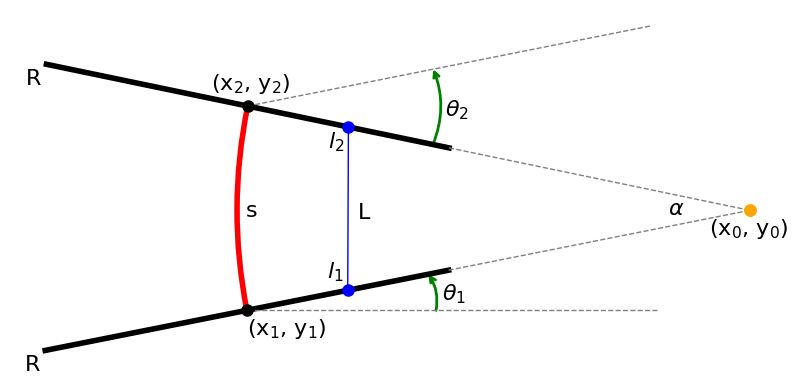

In [201]:
# Luyang want this figure
from matplotlib.patches import ConnectionPatch

def plot_geometry_for_luyang(geometry_result):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制rods（黑色，较粗）
    for rod in geometry_result['rods']:
        x_values = [rod[0][0], rod[1][0]]
        y_values = [rod[0][1], rod[1][1]]
        ax.plot(x_values, y_values, color='black', linewidth=4)
    
    # 绘制arcs（红色，较粗）
    for arc in geometry_result['arcs']:
        center = arc['center']
        radius = arc['radius']
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        if radius != float('inf'):
            arc_patch = Arc(center, 2*radius, 2*radius,
                            angle=0, theta1=np.degrees(start_angle),
                            theta2=np.degrees(end_angle),
                            color='red', linewidth=4)
            ax.add_patch(arc_patch)
        else: # 画直线，用line参数
            x_values = [arc['line'][0][0], arc['line'][1][0]]
            y_values = [arc['line'][0][1], arc['line'][1][1]]
            ax.plot(x_values, y_values, color='red', linewidth=2)
    
    # 绘制strings（蓝色，较细）
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        ax.plot(x_values, y_values, color='blue', linewidth=1)

    # 绘制圆心，橙色点
    for arc in geometry_result['arcs']:
        center = arc['center']
        ax.plot(center[0], center[1], 'o', color='orange', markersize=8)

    # 绘制rod结束点到圆心的虚线，灰色
    for arc in geometry_result['arcs']:
        center = arc['center']
        for rod in geometry_result['rods']:
            rod_end = rod[1]
            ax.plot([rod_end[0], center[0]], [rod_end[1], center[1]], '--', color='gray', linewidth=1)

    # 绘制圆心，橙色点
    for arc in geometry_result['arcs']:
        center = arc['center']
        ax.plot(center[0], center[1], 'o', color='orange', markersize=8)

    # 圆心下面标注x0,y0
    for arc in geometry_result['arcs']:
        center = arc['center']
        ax.text(center[0]-0.2, center[1]-0.12, "(x$_0$, y$_0$)", color='black', fontsize=16)

    # 标注弧的角度为alpha
    for arc in geometry_result['arcs']:
        center = arc['center']
        radius = arc['radius']
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        alpha = np.degrees(end_angle - start_angle)
        ax.text(center[0]-0.4, center[1]-0.02, "$\\alpha$", color='black', fontsize=16)

    # 标注string的长度为L
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        x_center = (x_values[0] + x_values[1]) / 2
        y_center = (y_values[0] + y_values[1]) / 2
        L = np.sqrt((x_values[1] - x_values[0])**2 + (y_values[1] - y_values[0])**2)
        ax.text(x_center+0.05, y_center-0.05, "L", color='black', fontsize=16)

    # 从弧的终点端点往X轴正方向画虚线，长度为2，灰色
    for arc in geometry_result['arcs']:
        end_angle = arc['end_angle']
        x_center = arc['center'][0]
        y_center = arc['center'][1]
        x_end = x_center + arc['radius'] * np.cos(end_angle)
        y_end = y_center + arc['radius'] * np.sin(end_angle)
        ax.plot([x_end, x_end+2], [y_end, y_end], '--', color='gray', linewidth=1)

    # 从弧的起点端点往与底部rod平行（相同角度）的方向画虚线，长度为2，灰色。需要先求出底部rod的角度
    rod_0_angle = np.arctan2(geometry_result['rods'][0][1][1] - geometry_result['rods'][0][0][1], geometry_result['rods'][0][1][0] - geometry_result['rods'][0][0][0])
    for arc in geometry_result['arcs']:
        start_angle = arc['start_angle']
        x_center = arc['center'][0]
        y_center = arc['center'][1]
        x_start = x_center + arc['radius'] * np.cos(start_angle)
        y_start = y_center + arc['radius'] * np.sin(start_angle)
        ax.plot([x_start, x_start+2*np.cos(rod_0_angle)], [y_start, y_start+2*np.sin(rod_0_angle)], '--', color='gray', linewidth=1)

    # 在弧的两端点分别标注x1,y1和x2,y2
    for arc in geometry_result['arcs']:
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        x_center = arc['center'][0]
        y_center = arc['center'][1]
        x_start = x_center + arc['radius'] * np.cos(start_angle)
        y_start = y_center + arc['radius'] * np.sin(start_angle)
        x_end = x_center + arc['radius'] * np.cos(end_angle)
        y_end = y_center + arc['radius'] * np.sin(end_angle)
        ax.text(x_end, y_end - 0.12, "(x$_1$, y$_1$)", color='black', fontsize=16)
        ax.text(x_start-0.18, y_start + 0.08, "(x$_2$, y$_2$)", color='black', fontsize=16)

    # 在弧的两端画点
    for arc in geometry_result['arcs']:
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        x_center = arc['center'][0]
        y_center = arc['center'][1]
        x_start = x_center + arc['radius'] * np.cos(start_angle)
        y_start = y_center + arc['radius'] * np.sin(start_angle)
        x_end = x_center + arc['radius'] * np.cos(end_angle)
        y_end = y_center + arc['radius'] * np.sin(end_angle)
        ax.plot(x_start, y_start, 'o', color='black', markersize=8)
        ax.plot(x_end, y_end, 'o', color='black', markersize=8)

    # 画一个弯的箭头，弯的箭头的起点是(0.92,0)，弯的箭头的弧心是弧的终点，角度是end_angle。注意不是直线箭头，也不是指向弧心
    for arc in geometry_result['arcs']:
        end_angle = arc['end_angle']
        x_center = arc['center'][0]
        y_center = arc['center'][1]
        x_end = x_center + arc['radius'] * np.cos(end_angle)
        y_end = y_center + arc['radius'] * np.sin(end_angle)

        # 计算rod的角度
        rod_angle = np.arctan2(geometry_result['rods'][0][1][1] - geometry_result['rods'][0][0][1], geometry_result['rods'][0][1][0] - geometry_result['rods'][0][0][0])

        x_target = x_end + 0.9 * np.cos(rod_angle)
        y_target = y_end + 0.9 * np.sin(rod_angle)
        
        arrow_start = (0.92, 0)
        arrow_end = (x_target, y_target)
        
        curved_arrow = ConnectionPatch(
            xyA=arrow_start, xyB=arrow_end, 
            coordsA="data", coordsB="data",
            axesA=ax, axesB=ax,
            arrowstyle="->", connectionstyle="arc3,rad="+str(rod_angle),
            color="green", linewidth=2
        )
        
        ax.add_artist(curved_arrow)

    # 画另一个弯的箭头，弯的箭头的起点是rod1的中点偏移0.92，终点是到与底部rod平行的那条虚线上
    for arc in geometry_result['arcs']:
        # 计算rod的角度
        rod_angle = np.arctan2(geometry_result['rods'][0][1][1] - geometry_result['rods'][0][0][1], 
                            geometry_result['rods'][0][1][0] - geometry_result['rods'][0][0][0])

        # 计算rod1的中点
        rod1_midpoint = ((geometry_result['rods'][1][0][0] + geometry_result['rods'][1][1][0]) / 2,
                        (geometry_result['rods'][1][0][1] + geometry_result['rods'][1][1][1]) / 2)

        # 计算箭头终点（到与底部rod平行的那条虚线上）
        arrow_end = (rod1_midpoint[0] + 0.92 * np.cos(rod_angle),
                    rod1_midpoint[1] + 0.92 * np.sin(rod_angle))

        # 计算箭头起点，先找出顶部rod的向量
        V_rod1 = np.array([geometry_result['rods'][1][1][0] - geometry_result['rods'][1][0][0],
                        geometry_result['rods'][1][1][1] - geometry_result['rods'][1][0][1]])
        # 然后将向量标准化
        V_rod1 = -V_rod1 / np.linalg.norm(V_rod1)
        # 然后乘以0.92，加到rod1的中点上
        arrow_start = (rod1_midpoint[0] - 0.92 * V_rod1[0], rod1_midpoint[1] - 0.92 * V_rod1[1])
        
        arrow_rad = rod_angle

        curved_arrow = ConnectionPatch(
            xyA=arrow_start, xyB=arrow_end,
            coordsA="data", coordsB="data",
            axesA=ax, axesB=ax,
            arrowstyle="->", connectionstyle=f"arc3,rad={arrow_rad}",
            color="green", linewidth=2
        )

        ax.add_artist(curved_arrow)

    # 在弧的两端点的右侧分别标注theta1和theta2
    for arc in geometry_result['arcs']:
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        x_center = arc['center'][0]
        y_center = arc['center'][1]
        x_start = x_center + arc['radius'] * np.cos(start_angle)
        y_start = y_center + arc['radius'] * np.sin(start_angle)
        x_end = x_center + arc['radius'] * np.cos(end_angle)
        y_end = y_center + arc['radius'] * np.sin(end_angle)
        ax.text(x_end + 0.95, y_end + 0.05, "$\\theta_1$", color='black', fontsize=16)
        ax.text(x_start + 0.96, y_start - 0.05, "$\\theta_2$", color='black', fontsize=16)

    # 在string的两端画点
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        ax.plot(x_values, y_values, 'o', color='blue', markersize=8)

    # 在string两端点的左边标注l1和l2
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        x_center = (x_values[0] + x_values[1]) / 2
        y_center = (y_values[0] + y_values[1]) / 2
        l1 = np.sqrt((x_values[0] - x_center)**2 + (y_values[0] - y_center)**2)
        l2 = np.sqrt((x_values[1] - x_center)**2 + (y_values[1] - y_center)**2)
        ax.text(x_values[0] - 0.1, y_values[0] + 0.06, "$l_1$", color='black', fontsize=16)
        ax.text(x_values[1] - 0.1, y_values[1] - 0.1, "$l_2$", color='black', fontsize=16)

    # 在Rod的左侧的端点处分别标注R，作为Rod的标记
    for rod in geometry_result['rods']:
        x_values = [rod[0][0], rod[1][0]]
        y_values = [rod[0][1], rod[1][1]]
        ax.text(x_values[0] - 0.1, y_values[0] - 0.1, "R", color='black', fontsize=16)

    # 在Arc中点的右侧标注s，作为Arc的标记
    for arc in geometry_result['arcs']:
        center = arc['center']
        ax.text(center[0] - 2.45, center[1] - 0.03, "s", color='black', fontsize=16)
    
    # 设置坐标轴等比例
    ax.set_aspect('equal', 'box')

    # 去掉坐标轴
    plt.axis('off')
    
    # 不显示网格
    plt.grid(False)
    
    # 自动调整坐标轴范围
    ax.autoscale()
    
    # 显示图形
    plt.show()

l = [0.5,0.5]  # 示例l数组
target_length = 0.8  # 目标总长度
arc_length = 1  # arc的长度
rod_length = 2  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = np.pi/16  # 起始角度

optimal_string_length = optimize_radians_get_string_length(l, target_length, x1, y1, theta1, arc_length)
optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, l)
geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, l)

plot_geometry_for_luyang(geometry)

In [266]:
# Devin want this figure
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}

test_cases = {
    # "w":["R3", "R3", "R3", "R3", "L2", "L3", "L2", "R3", "R3", "R3", "R3", "R3"],
    "s":["R3", "R3", "R3", "R3", "R3", "R3", "L3", "L3", "L3", "L3", "L3", "L3"]
}

mapped_test_cases = {}
for key, value in test_cases.items():
    mapped_test_cases[key] = [wiring_mapping[v] for v in value]

max_lengths = {}
for key, value in mapped_test_cases.items():
    max_lengths[key] = sum(get_original_string_length(value, arc_length))

geometry_results = []
for key, case, length in zip(max_lengths.keys(), mapped_test_cases.values(), max_lengths.values()):
    print(f"Case {key}: {case}, max length: {length}")
    optimal_string_length = get_original_string_length(case, arc_length) # 初始值
    for i in tqdm.tqdm(range(80)):
        if i == 0:
            target_length = length - 0.05
        else:
            target_length = length - i
        optimal_string_length = optimize_radians_get_string_length(case, target_length, x1, y1, theta1, arc_length, optimal_string_length)
        optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, case)
        geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, case)
        geometry_results.append(geometry)


Case s: [10, 10, 10, 10, 10, 10, -10, -10, -10, -10, -10, -10], max length: 206.9072480941474


100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


In [ ]:
def plot_geometry_space(geometry_results):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制arcs，RGB渐变，A固定0.5
    RGBAs = []
    # 生成渐变的RGB颜色
    for i in range(81):
        RGBAs.append((i/80, 0, 1-i/80, 1))
    RGBAs = RGBAs[::-1] 
    print(RGBAs)
    for color, geometry_result in zip(RGBAs, geometry_results):
        for arc in geometry_result['arcs']:
            center = arc['center']
            radius = arc['radius']
            start_angle = arc['start_angle']
            end_angle = arc['end_angle']
            if radius != float('inf'):
                arc_patch = Arc(center, 2*radius, 2*radius,
                                angle=0, theta1=np.degrees(start_angle),
                                theta2=np.degrees(end_angle),
                                color=color, linewidth=1)
                ax.add_patch(arc_patch)
            else: # 画直线，用line参数
                x_values = [arc['line'][0][0], arc['line'][1][0]]
                y_values = [arc['line'][0][1], arc['line'][1][1]]
                ax.plot(x_values, y_values, color='red', linewidth=1)

    # 在右侧画一个colorbar，表示收缩长度的变化，范围从[0,-80]
    cmap = LinearSegmentedColormap.from_list("custom", [(1,0,0,1), (0,0,1,1)])
    norm = plt.Normalize(0, 80)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, label='Contraction Length (mm)', pad=0.1)
    cbar.ax.invert_yaxis()  # 反转colorbar的方向
    
    # 设置坐标轴等比例
    ax.set_aspect('equal', 'box')
    
    # 添加标题和标签
    # plt.title('`w` Shape Workspace from 0mm to 80mm (1mm per datapoint)')
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')

    plt.rcParams['font.size'] = 16
    
    # 显示网格
    plt.grid(True)
    
    # 自动调整坐标轴范围
    ax.autoscale()
    
    # 显示图形
    plt.show()

print(matplotlib.get_cachedir())
plot_geometry_space(geometry_results)

In [ ]:
# The figure for simulate w

def plot_geometry_for_compare(geometry_result, x_range=(-10, 200), y_range=(-175, 15)):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制rods（黑色，较粗）
    for rod in geometry_result['rods']:
        x_values = [rod[0][0], rod[1][0]]
        y_values = [rod[0][1], rod[1][1]]
        ax.plot(x_values, y_values, color='black', linewidth=2)
    
    # 绘制arcs（红色，较粗）
    for arc in geometry_result['arcs']:
        center = arc['center']
        radius = arc['radius']
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        if radius != float('inf'):
            arc_patch = Arc(center, 2*radius, 2*radius,
                            angle=0, theta1=np.degrees(start_angle),
                            theta2=np.degrees(end_angle),
                            color='red', linewidth=2)
            ax.add_patch(arc_patch)
        else: # 画直线，用line参数
            x_values = [arc['line'][0][0], arc['line'][1][0]]
            y_values = [arc['line'][0][1], arc['line'][1][1]]
            ax.plot(x_values, y_values, color='red', linewidth=2)
    
    # 绘制strings（蓝色，较细）
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        ax.plot(x_values, y_values, color='blue', linewidth=1)
    
    # 设置坐标轴等比例
    ax.set_aspect('equal', 'box')
    
    # 添加标题和标签
    # plt.title('Geometry Visualization')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    
    # 显示网格
    plt.grid(False)
        
    # 设置坐标轴范围
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    # 显示图形
    plt.show()

# Frame use [0, 10, 17, 24, 32, 39, 48]
w_frames_geometry_results = [geometry_results[i] for i in [0, 10, 17, 24, 32, 39, 48]]
for i, geometry_result in enumerate(w_frames_geometry_results):
    plot_geometry_for_compare(geometry_result)

Case n3: [3, 3, -0.5, 10, 3, 0.5, 0.5, -10, -3, -0.5, -0.5, -0.5], max length: 206.98643231167011


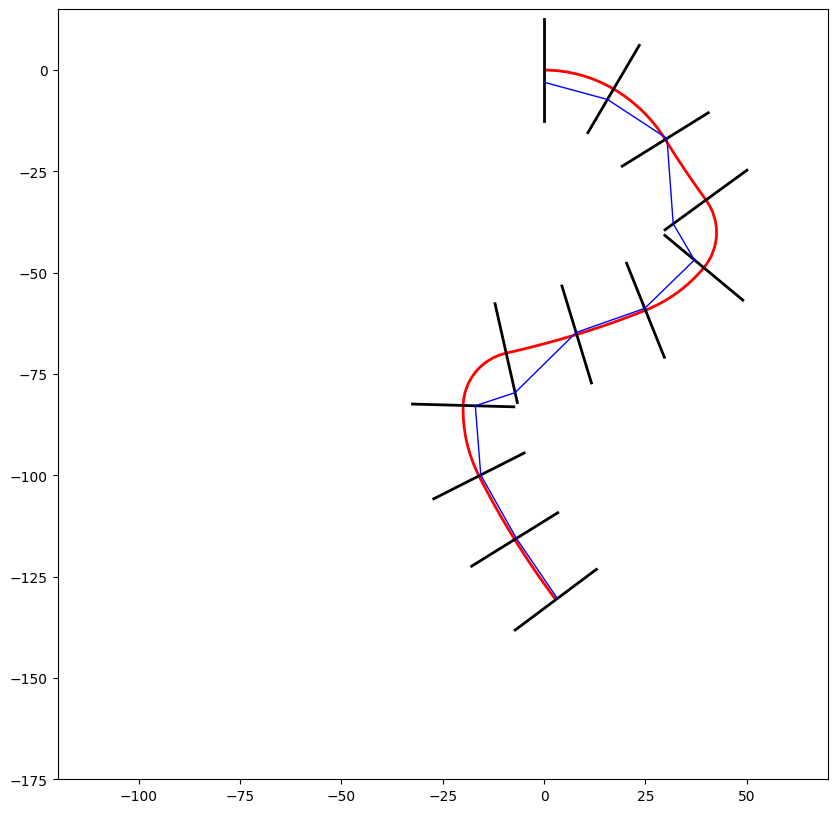

In [259]:
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}

test_cases = {
    # "c":["R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3"],
    "n3":["R1", "R1", "L0", "R3", "R1", "R0", "R0", "L3", "L1", "L0", "L0", "L0"],
    # "s2":["R3", "R3", "R3", "R2", "R2", "R1", "L1", "L1", "L2", "L2", "L3", "L3"],
    # "s":["R3", "R3", "R3", "R3", "R3", "R3", "L3", "L3", "L3", "L3", "L3", "L3"],
    # "w":["R3", "R3", "R3", "R3", "L2", "L3", "L2", "R3", "R3", "R3", "R3", "R3"]
}

mapped_test_cases = {}
for key, value in test_cases.items():
    mapped_test_cases[key] = [wiring_mapping[v] for v in value]

max_lengths = {}
for key, value in mapped_test_cases.items():
    max_lengths[key] = sum(get_original_string_length(value, arc_length))

# step_lengths = [36, 30, 45, 44, 48] # Frame use 7
step_lengths = [33] # Frame use 7, n3

geometry_results_2 = []

for key, case, length, step_length in zip(max_lengths.keys(), mapped_test_cases.values(), max_lengths.values(), step_lengths):
    # [16.39845245 16.9120018  20.80683737  5.89862232 16.69731642 17.95680873 20.80683737  5.89862226 16.69731618 17.9568087  17.95680871]
    optimal_string_length = [16.39845245, 16.9120018, 20.80683737, 5.89862232, 16.69731642, 17.95680873, 20.80683737, 5.89862226, 16.69731618, 17.9568087, 17.95680871] # n3的初始值
    
    print(f"Case {key}: {case}, max length: {length}")
    
    # optimal_string_length = get_original_string_length(case, arc_length) # 初始值
    optimal_string_length = optimize_radians_get_string_length(case, length - step_length, x1, y1, theta1, arc_length, optimal_string_length)
    optimal_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, case)
    geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, case)
    geometry_results_2.append(geometry)

for i, geometry_result in enumerate(geometry_results_2):
    plot_geometry_for_compare(geometry_result, x_range=(-120, 70), y_range=(-175, 15))


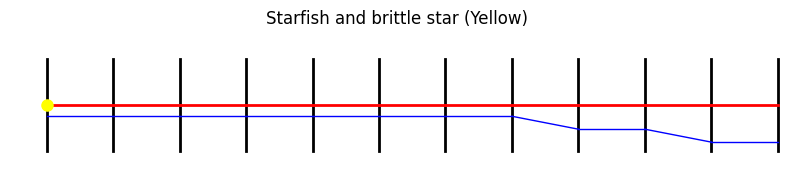

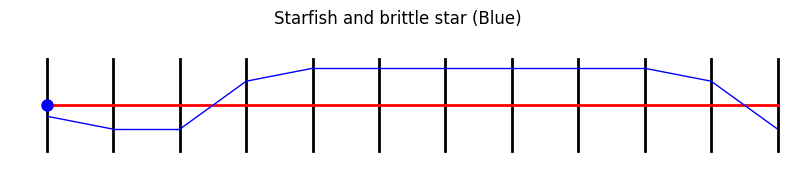

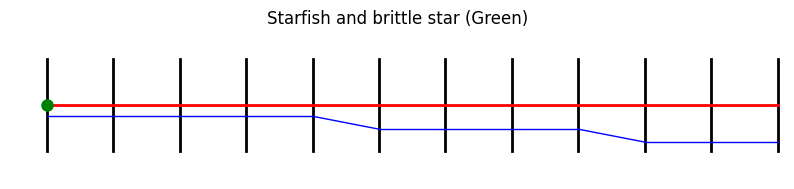

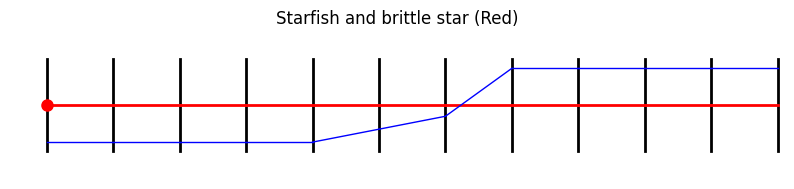

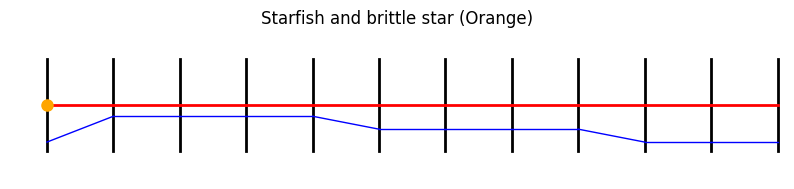

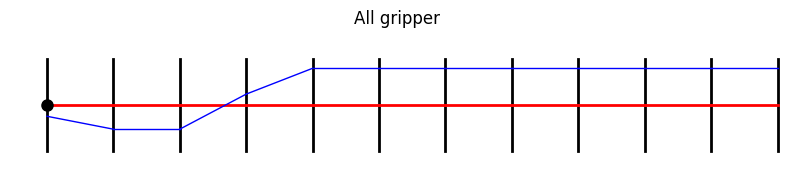

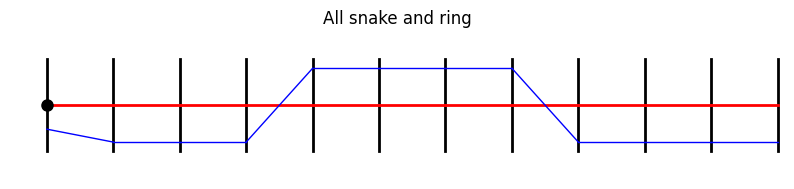

In [11]:
# Fine, I will do this figure

def plot_geometry_for_threading(geometry_result, x_range=(-10, 200), y_range=(-20, 20), title=None, start_color='black'):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制rods（黑色，较粗）
    for rod in geometry_result['rods']:
        x_values = [rod[0][0], rod[1][0]]
        y_values = [rod[0][1], rod[1][1]]
        ax.plot(x_values, y_values, color='black', linewidth=2)
    
    # 绘制arcs（红色，较粗）
    for arc in geometry_result['arcs']:
        center = arc['center']
        radius = arc['radius']
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        if radius != float('inf'):
            arc_patch = Arc(center, 2*radius, 2*radius,
                            angle=0, theta1=np.degrees(start_angle),
                            theta2=np.degrees(end_angle),
                            color='red', linewidth=2)
            ax.add_patch(arc_patch)
        else: # 画直线，用line参数
            x_values = [arc['line'][0][0], arc['line'][1][0]]
            y_values = [arc['line'][0][1], arc['line'][1][1]]
            ax.plot(x_values, y_values, color='red', linewidth=2)
    
    # 绘制strings（蓝色，较细）
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        ax.plot(x_values, y_values, color='blue', linewidth=1)

    # 在最左侧rod的中点处画一个黑色的点，表示起始点
    rod = geometry_result['rods'][0]
    center = [(rod[0][0] + rod[1][0]) / 2, (rod[0][1] + rod[1][1]) / 2]
    ax.plot(center[0], center[1], 'o', color=start_color, markersize=8)
    
    # 设置坐标轴等比例
    ax.set_aspect('equal', 'box')
    
    # 在左侧添加标题
    if title:
        plt.title(title)
    
    # 显示网格
    plt.grid(False)

    # 不显示坐标轴
    plt.axis('off')

    
        
    # 设置坐标轴范围
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    # 显示图形
    plt.show()

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}

# 输入`["R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3", "R3"]`格式的数据，生成初始状态的geometry_result
def generate_threading_geometry(threading):
    arc_length = 18  # arc的长度
    rod_length = 25  # rod的长度
    x1, y1 = 0, 0  # 起始点
    theta1 = -np.pi/2  # 起始角度

    # 不使用optimize_radians_get_string_length，弧度都是0
    # optimal_string_length = get_original_string_length(threading, arc_length)
    optimal_radians = [0] * (len(threading) - 1)
    geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, threading)

    return geometry

test_cases = {
    "Starfish and brittle star (Yellow)":(["R1", "R1", "R1", "R1", "R1", "R1", "R1", "R1", "R2", "R2", "R3", "R3"], "yellow"),
    "Starfish and brittle star (Blue)":(["R1", "R2", "R2", "L2", "L3", "L3", "L3", "L3", "L3", "L3", "L2", "R2"], "blue"),
    "Starfish and brittle star (Green)":(["R1", "R1", "R1", "R1", "R1", "R2", "R2", "R2", "R2", "R3", "R3", "R3"], "green"),
    "Starfish and brittle star (Red)":(["R3", "R3", "R3", "R3", "R3", "R2", "R1", "L3", "L3", "L3", "L3", "L3"], "red"),
    "Starfish and brittle star (Orange)":(["R3", "R1", "R1", "R1", "R1", "R2", "R2", "R2", "R2", "R3", "R3", "R3"], "orange"),
    "All gripper":(["R1", "R2", "R2", "L1", "L3", "L3", "L3", "L3", "L3", "L3", "L3", "L3"], "black"),
    "All snake and ring":(["R2", "R3", "R3", "R3", "L3", "L3", "L3", "L3", "R3", "R3", "R3", "R3"], "black"),
}
# 设置matplotlib的字体为arial
# plt.rcParams['font.family'] = 'arial'

for key, threading in test_cases.items():
    res_geometry = generate_threading_geometry([wiring_mapping[v] for v in threading[0]])
    plot_geometry_for_threading(res_geometry, start_color = threading[1], title=key)